In [1]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise

from model_testing_util import cross_validation
from load_data import load_heart_data, load_tweet_data

In [2]:
train_X, test_X, train_y, test_y = load_heart_data("heart_dataset.csv")

In [3]:
print("Shape of Train X: ", train_X.shape, ", Type: ", type(train_X))
print("Shape of Test X: ", test_X.shape, ", Type: ", type(test_X))
print("Shape of Train y: ", train_y.shape, ", Type: ", type(train_y))
print("Shape of Test y: ", test_y.shape, ", Type: ", type(test_y))

Shape of Train X:  (820, 13) , Type:  <class 'numpy.ndarray'>
Shape of Test X:  (205, 13) , Type:  <class 'numpy.ndarray'>
Shape of Train y:  (820,) , Type:  <class 'numpy.ndarray'>
Shape of Test y:  (205,) , Type:  <class 'numpy.ndarray'>


# Baseline Performance

Before testing out the new method explored in the project regarding the locally weighted trees, we will first test out the existing method we aim to improve upon, the random forest model.

In [4]:
# To find the best random forrest model, we need to tune the hyperparameters. Will do 
# so by performing a grid search 

grid_search_parameters = {'max_depth':[5, 10, 15, 30, 50, None], 
                          'n_estimators':[10, 25, 50, 100, 250, 500, 1000], 
                          'max_samples': [0.3, 0.5, 0.7, 0.8, 0.9, 1]}


In [16]:
random_forest_classifier = RandomForestClassifier(random_state=1)
random_forest_classifier_GS = GridSearchCV(random_forest_classifier, grid_search_parameters, cv=5, verbose=0)
random_forest_classifier_GS.fit(train_X, train_y)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [5, 10, 15, 30, 50, None],
                         'max_samples': [0.3, 0.5, 0.7, 0.8, 0.9, 1],
                         'n_estimators': [10, 25, 50, 100, 250, 500, 1000]})

In [17]:
print("Best Parameters: ", random_forest_classifier_GS.best_params_)
print("Best Score: ", random_forest_classifier_GS.best_score_)

Best Parameters:  {'max_depth': 10, 'max_samples': 0.7, 'n_estimators': 500}
Best Score:  0.9817073170731707


In [18]:
# Train the model with the best parameters:
random_forest_classifier = RandomForestClassifier(random_state=1, n_estimators=500, max_samples=0.7, max_depth=10)
random_forest_classifier.fit(train_X, train_y)
predictions = random_forest_classifier.predict(test_X)

print(classification_report(test_y, predictions, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.94444   0.97143       108
           1    0.94175   1.00000   0.97000        97

    accuracy                        0.97073       205
   macro avg    0.97087   0.97222   0.97071       205
weighted avg    0.97244   0.97073   0.97075       205



# Locally Weighted Random Forest

In [4]:
from locallyWeightedRandomForest import LocallyWeightedRandomForest
from sklearn.utils.estimator_checks import check_estimator

# Distance functions

In [5]:
def euclidean_distance(x_1:np.ndarray, x_2:np.ndarray) -> float:
    return np.linalg.norm(x_1 - x_2)

def manhattan_distance(x_1:np.ndarray, x_2:np.ndarray) -> float:
    return np.linalg.norm(x_1 - x_2, ord=1)

def cosine_similarity(x_1:np.ndarray, x_2:np.ndarray) -> float:
    return np.dot(x_1,x_2)/(np.linalg.norm(x_1)*np.linalg.norm(x_2))

def mean_distance(point:np.ndarray, dataset:np.ndarray, distance_function:callable = lambda a,b: 1)-> float:
    distance_sum = 0
    for p in dataset:
        distance_sum += distance_function(point, p)
    return distance_sum/len(dataset)

def distance_to_dataset_mean(point:np.ndarray, dataset:np.ndarray, distance_function:callable = lambda a,b: 1)-> float:
    mean_dataset_point = np.mean(dataset, axis=0)
    return distance_function(point, mean_dataset_point)

def median_distance(point:np.ndarray, dataset:np.ndarray, distance_function:callable = lambda a,b: 1)-> float:
    distances = []
    for p in dataset:
        distances.append(distance_function(point, p))
    return statistics.median(distances)

def nearest_k_distance_mean(k:int) -> callable:
    def _smallest_k_distances_mean(point:np.ndarray, dataset:np.ndarray, distance_function:callable = lambda a,b: 1) -> float:
        distances = np.zeros(len(dataset))
        for i in range(len(dataset)):
            distances[i] = distance_function(point, dataset[i])
        smallest_k_distaces = np.sort(distances)[:k]
        return np.mean(smallest_k_distaces, axis=0)

    return _smallest_k_distances_mean

### Best Performing LWRF

In [22]:

# To find the best locally weighted random forrest model, we need to tune the hyperparameters. Will do 
# so by performing a grid search 

grid_search_parameters = {'max_depth':[10, 30, 50], 
                          'n_estimators':[50, 100, 250, 500], 
                          'max_samples': [0.3, 0.5, 0.75, 1], 
                          'distance_function': [euclidean_distance, cosine_similarity], 
                          'distance_agg_func': [mean_distance, distance_to_dataset_mean, nearest_k_distance_mean(k=1), nearest_k_distance_mean(k=5)], 
                          'temp': [0.15, 0.5, 1] }


In [24]:
lwrf_GS = GridSearchCV(LocallyWeightedRandomForest(), grid_search_parameters, cv=5, verbose=3)
lwrf_GS.fit(train_X, train_y)


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
[CV 1/5] END distance_agg_func=<function mean_distance at 0x17a587250>, distance_function=<function euclidean_distance at 0x17a75c280>, max_depth=10, max_samples=0.3, n_estimators=50, temp=0.15;, score=0.951 total time=   0.3s
[CV 2/5] END distance_agg_func=<function mean_distance at 0x17a587250>, distance_function=<function euclidean_distance at 0x17a75c280>, max_depth=10, max_samples=0.3, n_estimators=50, temp=0.15;, score=0.963 total time=   0.2s
[CV 3/5] END distance_agg_func=<function mean_distance at 0x17a587250>, distance_function=<function euclidean_distance at 0x17a75c280>, max_depth=10, max_samples=0.3, n_estimators=50, temp=0.15;, score=0.957 total time=   0.2s
[CV 4/5] END distance_agg_func=<function mean_distance at 0x17a587250>, distance_function=<function euclidean_distance at 0x17a75c280>, max_depth=10, max_samples=0.3, n_estimators=50, temp=0.15;, score=0.921 total time=   0.2s
[CV 5/5] END distance_agg_f

In [17]:
print("Best Parameters: ", lwrf_GS.best_params_)
print("Best Score: ", lwrf_GS.best_score_)

Best Parameters:  {'distance_agg_func': <function mean_distance at 0x177465c60>, 'distance_function': <function cosine_similarity at 0x177465b40>, 'max_depth': 15, 'max_samples': 0.75, 'n_estimators': 100, 'temp': 0.15}
Best Score:  0.9841463414634146


In [14]:
cosine_similarity([[1]],[[5]])

array([[1.]])

In [6]:
# Train the model with the best parameters:
lwrf = LocallyWeightedRandomForest(n_estimators=100, temp=0.15, distance_aggregation_function=mean_distance, distance_function=euclidean_distance, max_depth=50, max_samples=0.75)
lwrf.fit(train_X, train_y)
predictions = lwrf.predict(test_X)

print(classification_report(test_y, predictions, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.97222   0.98592       108
           1    0.97000   1.00000   0.98477        97

    accuracy                        0.98537       205
   macro avg    0.98500   0.98611   0.98534       205
weighted avg    0.98580   0.98537   0.98537       205



In [7]:
distances = lwrf.analyze_distances(test_X)

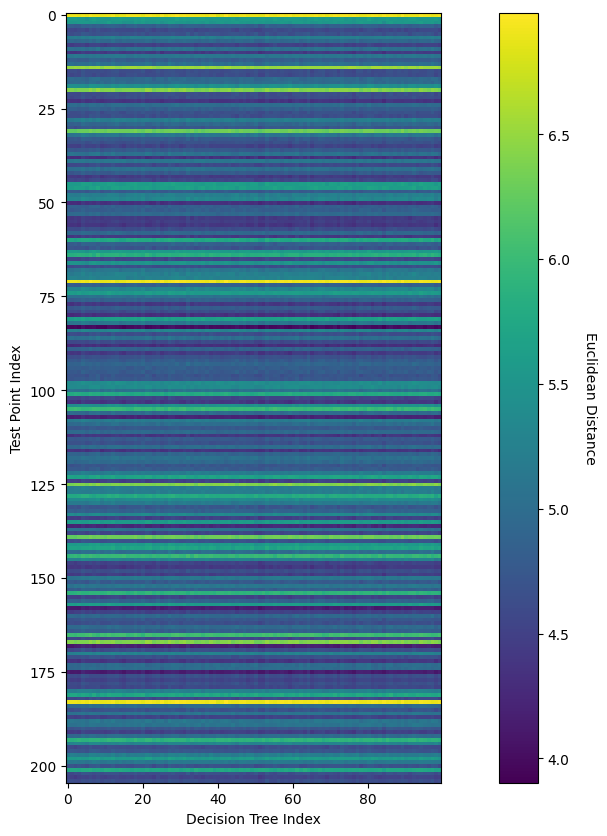

In [25]:
# plot an image of the distances
fig, ax = plt.subplots(figsize=(15,10))
vals = ax.imshow(distances)
# plt.axis('off')
cbar = plt.colorbar(vals, ax=ax)
cbar.set_label('Euclidean Distance', rotation=270, labelpad=20)
ax.set_xlabel('Decision Tree Index')
ax.set_ylabel('Test Point Index')
plt.savefig('distances.pdf', bbox_inches='tight')

# Experiments

### Comparing sample sizes vs performance 

For this graph, we will keep the number of estimators constant at 500. 

In [22]:
euc_mean_acc = []
euc_median_acc = []
euc_dataset_mean = []
k_1_euc_mean_acc = []
k_5_euc_mean_acc = []
k_10_euc_mean_acc = []
k_20_euc_mean_acc = []
manhattan_mean_acc = []

In [ ]:
# For the random forest, we will try various values for the portion of the population we 
# sample the data from 
sample_sizes = np.arange(0.1, 1.01, 0.1)

for size in sample_sizes:
    euc_mean_acc.append(cross_validation(X=train_X, 
                                         y=train_y, 
                                         model=LocallyWeightedRandomForest(n_estimators=500, 
                                                                           max_samples=size, 
                                                                           max_depth=10, 
                                                                           temp=1.0, 
                                                                           distance_agg_func=mean_distance, 
                                                                           distance_function=euclidean_distance) , 
                                         folds=5, 
                                         verbose=True))
    euc_median_acc.append(cross_validation(X=train_X, y=train_y, model=lwrf, temperature=1.0, distance_agg_func=mean_distance, distance_function=euclidean_distance, folds=5, verbose=True))


In [51]:

for size in sample_sizes:
    lwrf = LocallyWeightedRandomForest(n_estimators=500, max_samples=size, max_depth=10)
    k_5_euc_mean_acc.append(cross_validation(X=train_X, y=train_y, model=lwrf, temperature=1.0, distance_agg_func=nearest_k_distance_mean(k=5), distance_function=euclidean_distance, folds=5, verbose=True))
    k_10_euc_mean_acc.append(cross_validation(X=train_X, y=train_y, model=lwrf, temperature=1.0, distance_agg_func=nearest_k_distance_mean(k=10), distance_function=euclidean_distance, folds=5, verbose=True))
    k_20_euc_mean_acc.append(cross_validation(X=train_X, y=train_y, model=lwrf, temperature=1.0, distance_agg_func=nearest_k_distance_mean(k=20), distance_function=euclidean_distance, folds=5, verbose=True))


Fold Accuracy:  0.9512195121951219
Fold Accuracy:  0.9390243902439024
Fold Accuracy:  0.9329268292682927
Fold Accuracy:  0.8475609756097561
Fold Accuracy:  0.9329268292682927
Fold Accuracy:  0.9573170731707317
Fold Accuracy:  0.8658536585365854
Fold Accuracy:  0.8963414634146342
Fold Accuracy:  0.8353658536585366
Fold Accuracy:  0.9085365853658537
Fold Accuracy:  0.9390243902439024
Fold Accuracy:  0.8780487804878049
Fold Accuracy:  0.9024390243902439
Fold Accuracy:  0.823170731707317
Fold Accuracy:  0.9390243902439024
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9512195121951219
Fold Accuracy:  0.9817073170731707
Fold Accuracy:  0.9146341463414634
Fold Accuracy:  0.9695121951219512
Fold Accuracy:  0.9573170731707317
Fold Accuracy:  0.9512195121951219
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9329268292682927
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9512195121951219
Fold Accuracy:  0.9451219512195121
Fold Accuracy:  0.9573170731707317
Fold Accuracy:  0.932

In [57]:

for size in sample_sizes:
    lwrf = LocallyWeightedRandomForest(n_estimators=300, max_samples=size, max_depth=10)
    k_1_euc_mean_acc.append(cross_validation(X=train_X, y=train_y, model=lwrf, temperature=1.0, distance_agg_func=nearest_k_distance_mean(k=1), distance_function=euclidean_distance, folds=5, verbose=True))


Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9512195121951219
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.926829268292683
Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.9573170731707317
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.9512195121951219
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.9695121951219512
Fold Accuracy:  1.0
Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  1.0
Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9878

In [42]:
from sklearn.model_selection import cross_val_score

In [48]:
random_forest_acc = []
for size in sample_sizes:
    model = RandomForestClassifier(random_state=0, n_estimators=300, max_samples=size, max_depth=10)
    random_forest_acc.append(np.mean(cross_val_score(model, train_X, train_y, cv=5)))

In [77]:
my_test_model = LocallyWeightedRandomForest(n_estimators=300, max_depth=10, max_samples=0.8)
my_test_model.fit(train_X, train_y)
pred = my_test_model.predict(test_X,temperature=1, distance_aggregation_function=nearest_k_distance_mean(k=10), distance_function=euclidean_distance )
print(classification_report(test_y, pred, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.97222   0.98592       108
           1    0.97000   1.00000   0.98477        97

    accuracy                        0.98537       205
   macro avg    0.98500   0.98611   0.98534       205
weighted avg    0.98580   0.98537   0.98537       205



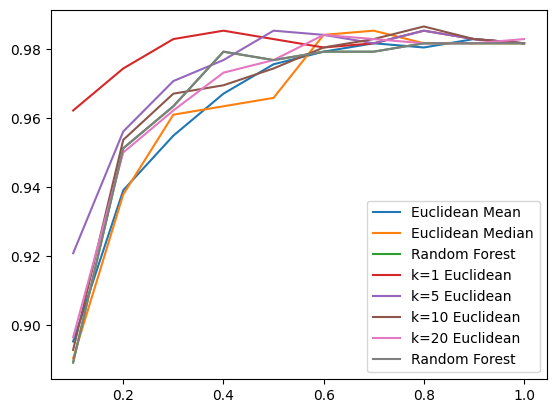

In [58]:
plt.plot(sample_sizes, euc_mean_acc, label = "Euclidean Mean")
plt.plot(sample_sizes, euc_median_acc, label = "Euclidean Median")
plt.plot(sample_sizes, random_forest_acc, label = "Random Forest")
plt.plot(sample_sizes, k_1_euc_mean_acc, label = "k=1 Euclidean")
plt.plot(sample_sizes, k_5_euc_mean_acc, label = "k=5 Euclidean")
plt.plot(sample_sizes, k_10_euc_mean_acc, label = "k=10 Euclidean")
plt.plot(sample_sizes, k_20_euc_mean_acc, label = "k=20 Euclidean")
plt.plot(sample_sizes, random_forest_acc, label = "Random Forest")
plt.legend()
plt.show()

In [74]:
max(k_5_euc_mean_acc)

0.9853658536585366

In [73]:
max(k_1_euc_mean_acc)

0.9853658536585366

In [91]:
lwrf = LocallyWeightedRandomForest(n_estimators=300, max_samples=0.4, max_depth=10)
k_1_temp_scores = cross_validation_temperature_range(X=train_X, y=train_y, model=lwrf, temperature_list=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.75,0.85, 1, 2, 5, 10, 15, 25], distance_agg_func=nearest_k_distance_mean(k=1), distance_function=euclidean_distance, folds=5, verbose=True)


Fold Accuracy: 
Temp:  0.15 , fold acc:  0.975609756097561
Temp:  0.25 , fold acc:  0.975609756097561
Temp:  0.35 , fold acc:  0.975609756097561
Temp:  0.45 , fold acc:  0.975609756097561
Temp:  0.55 , fold acc:  0.975609756097561
Temp:  0.65 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.85 , fold acc:  0.975609756097561
Temp:  1 , fold acc:  0.975609756097561
Temp:  2 , fold acc:  0.975609756097561
Temp:  5 , fold acc:  0.9634146341463414
Temp:  10 , fold acc:  0.9634146341463414
Temp:  15 , fold acc:  0.9634146341463414
Temp:  25 , fold acc:  0.9634146341463414
Fold Accuracy: 
Temp:  0.15 , fold acc:  0.9878048780487805
Temp:  0.25 , fold acc:  0.9878048780487805
Temp:  0.35 , fold acc:  0.9878048780487805
Temp:  0.45 , fold acc:  0.9878048780487805
Temp:  0.55 , fold acc:  0.9878048780487805
Temp:  0.65 , fold acc:  0.9878048780487805
Temp:  0.75 , fold acc:  0.9878048780487805
Temp:  0.75 , fold acc:  0

In [93]:
euc_mean_temp_scores = cross_validation_temperature_range(X=train_X, y=train_y, model=lwrf, temperature_list=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.75,0.85, 1, 2, 5, 10, 15, 25], distance_agg_func=mean_distance, distance_function=euclidean_distance, folds=5, verbose=True)


Fold Accuracy: 
Temp:  0.15 , fold acc:  0.975609756097561
Temp:  0.25 , fold acc:  0.9634146341463414
Temp:  0.35 , fold acc:  0.9634146341463414
Temp:  0.45 , fold acc:  0.9634146341463414
Temp:  0.55 , fold acc:  0.9634146341463414
Temp:  0.65 , fold acc:  0.9634146341463414
Temp:  0.75 , fold acc:  0.9634146341463414
Temp:  0.75 , fold acc:  0.9634146341463414
Temp:  0.85 , fold acc:  0.9634146341463414
Temp:  1 , fold acc:  0.9634146341463414
Temp:  2 , fold acc:  0.9634146341463414
Temp:  5 , fold acc:  0.9634146341463414
Temp:  10 , fold acc:  0.9634146341463414
Temp:  15 , fold acc:  0.9634146341463414
Temp:  25 , fold acc:  0.9634146341463414
Fold Accuracy: 
Temp:  0.15 , fold acc:  0.9878048780487805
Temp:  0.25 , fold acc:  0.9695121951219512
Temp:  0.35 , fold acc:  0.9695121951219512
Temp:  0.45 , fold acc:  0.9695121951219512
Temp:  0.55 , fold acc:  0.9695121951219512
Temp:  0.65 , fold acc:  0.9573170731707317
Temp:  0.75 , fold acc:  0.9573170731707317
Temp:  0.75 , fo

In [96]:
k_3_temp_scores = cross_validation_temperature_range(X=train_X, y=train_y, model=lwrf, temperature_list=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.75,0.85, 1, 2, 5, 10, 15, 25], distance_agg_func=nearest_k_distance_mean(k=3), distance_function=euclidean_distance, folds=5, verbose=True)


Fold Accuracy: 
Temp:  0.15 , fold acc:  0.975609756097561
Temp:  0.25 , fold acc:  0.975609756097561
Temp:  0.35 , fold acc:  0.975609756097561
Temp:  0.45 , fold acc:  0.975609756097561
Temp:  0.55 , fold acc:  0.975609756097561
Temp:  0.65 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.85 , fold acc:  0.975609756097561
Temp:  1 , fold acc:  0.975609756097561
Temp:  2 , fold acc:  0.9634146341463414
Temp:  5 , fold acc:  0.9634146341463414
Temp:  10 , fold acc:  0.9634146341463414
Temp:  15 , fold acc:  0.9634146341463414
Temp:  25 , fold acc:  0.9634146341463414
Fold Accuracy: 
Temp:  0.15 , fold acc:  0.975609756097561
Temp:  0.25 , fold acc:  0.9817073170731707
Temp:  0.35 , fold acc:  0.9817073170731707
Temp:  0.45 , fold acc:  0.9878048780487805
Temp:  0.55 , fold acc:  0.9878048780487805
Temp:  0.65 , fold acc:  0.9878048780487805
Temp:  0.75 , fold acc:  0.9878048780487805
Temp:  0.75 , fold acc:  0

In [98]:
k_5_temp_scores = cross_validation_temperature_range(X=train_X, y=train_y, model=lwrf, temperature_list=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.75,0.85, 1, 2, 5, 10, 15, 25], distance_agg_func=nearest_k_distance_mean(k=5), distance_function=euclidean_distance, folds=5, verbose=True)


Fold Accuracy: 
Temp:  0.15 , fold acc:  0.975609756097561
Temp:  0.25 , fold acc:  0.975609756097561
Temp:  0.35 , fold acc:  0.975609756097561
Temp:  0.45 , fold acc:  0.975609756097561
Temp:  0.55 , fold acc:  0.975609756097561
Temp:  0.65 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.85 , fold acc:  0.975609756097561
Temp:  1 , fold acc:  0.975609756097561
Temp:  2 , fold acc:  0.9634146341463414
Temp:  5 , fold acc:  0.9634146341463414
Temp:  10 , fold acc:  0.9634146341463414
Temp:  15 , fold acc:  0.9634146341463414
Temp:  25 , fold acc:  0.9634146341463414
Fold Accuracy: 
Temp:  0.15 , fold acc:  0.9878048780487805
Temp:  0.25 , fold acc:  0.9878048780487805
Temp:  0.35 , fold acc:  0.9878048780487805
Temp:  0.45 , fold acc:  0.9878048780487805
Temp:  0.55 , fold acc:  0.9878048780487805
Temp:  0.65 , fold acc:  0.9878048780487805
Temp:  0.75 , fold acc:  0.9817073170731707
Temp:  0.75 , fold acc:  

In [99]:
dataset_mean_temp_scores = cross_validation_temperature_range(X=train_X, y=train_y, model=lwrf, temperature_list=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.75,0.85, 1, 2, 5, 10, 15, 25], distance_agg_func=distance_to_dataset_mean, distance_function=euclidean_distance, folds=5, verbose=True)


Fold Accuracy: 
Temp:  0.15 , fold acc:  0.9817073170731707
Temp:  0.25 , fold acc:  0.975609756097561
Temp:  0.35 , fold acc:  0.975609756097561
Temp:  0.45 , fold acc:  0.975609756097561
Temp:  0.55 , fold acc:  0.975609756097561
Temp:  0.65 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.85 , fold acc:  0.975609756097561
Temp:  1 , fold acc:  0.975609756097561
Temp:  2 , fold acc:  0.975609756097561
Temp:  5 , fold acc:  0.975609756097561
Temp:  10 , fold acc:  0.975609756097561
Temp:  15 , fold acc:  0.975609756097561
Temp:  25 , fold acc:  0.975609756097561
Fold Accuracy: 
Temp:  0.15 , fold acc:  0.975609756097561
Temp:  0.25 , fold acc:  0.9817073170731707
Temp:  0.35 , fold acc:  0.9817073170731707
Temp:  0.45 , fold acc:  0.9817073170731707
Temp:  0.55 , fold acc:  0.9817073170731707
Temp:  0.65 , fold acc:  0.9817073170731707
Temp:  0.75 , fold acc:  0.9817073170731707
Temp:  0.75 , fold acc:  0.981

In [69]:
k_1_temp_scores

array([0.98292683, 0.98292683, 0.98292683, 0.98292683, 0.97804878,
       0.97195122, 0.9695122 , 0.9695122 , 0.9695122 ])

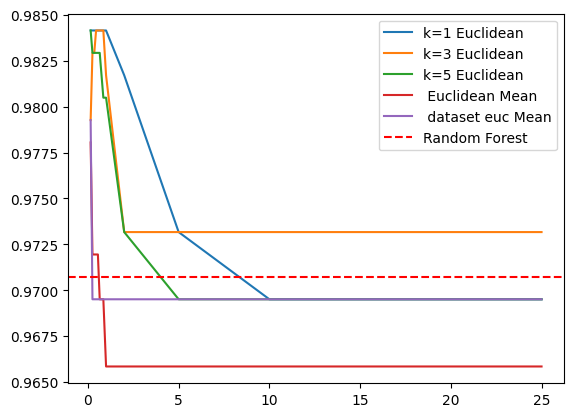

In [102]:
temperature_list=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.75,0.85, 1, 2, 5, 10, 15, 25]


# Baseline with random forest
model = RandomForestClassifier(random_state=1, n_estimators=300, max_samples=0.4, max_depth=10)
random_forest_cross_eval = np.mean(cross_val_score(model, train_X, train_y, cv=5))


plt.plot(temperature_list, k_1_temp_scores, label = "k=1 Euclidean")
plt.plot(temperature_list, k_3_temp_scores, label = "k=3 Euclidean")
plt.plot(temperature_list, k_5_temp_scores, label = "k=5 Euclidean")

plt.plot(temperature_list, euc_mean_temp_scores, label = " Euclidean Mean"  )
plt.plot(temperature_list, dataset_mean_temp_scores, label = " dataset euc Mean"  )

plt.axhline(y = random_forest_cross_eval, color = 'r', linestyle = '--', label = "Random Forest") 
plt.legend()
plt.show()

In [55]:
max(k_10_euc_mean_acc)

0.9865853658536586

In [15]:
cross_validation(X=train_X, y=train_y, model=lwrf, temperature=1.0, distance_agg_func=mean_distance, distance_function=euclidean_distance, folds=5, verbose=True)

Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9451219512195121
Fold Accuracy:  1.0


0.9817073170731707

In [16]:
cross_validation(X=train_X, y=train_y, model=lwrf, temperature=2.0, distance_agg_func=mean_distance, distance_function=euclidean_distance, folds=5, verbose=True)

Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  1.0


0.9829268292682926

In [33]:
cross_validation(X=train_X, y=train_y, model=lwrf, temperature=2.0, distance_agg_func=nearest_k_distance_mean(k=10), distance_function=euclidean_distance, folds=5, verbose=True)

Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.9451219512195121
Fold Accuracy:  1.0


0.9829268292682928

In [34]:
cross_validation(X=train_X, y=train_y, model=lwrf, temperature=2.0, distance_agg_func=nearest_k_distance_mean(k=1), distance_function=euclidean_distance, folds=5, verbose=True)

Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9817073170731707
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9878048780487805


0.9817073170731707